# Solving the affect of our device passing over different mass junctions
We can use the fact that the the gravitational potential at a point $\bm{r}$ is given by the convolution of $G/|\bm{r}|$ and $dm(\bm{r})$:

$$
V(\bm{r}) = -\int_{\mathbb{R}^3} \frac{G}{|\bm{\text{x}}-\bm{r}|}dm(\bm{\text{x}}) = -\int_{\mathbb{R}^3} \frac{G}{|\bm{\text{\text{x}}}-\bm{r}|}\rho(\bm{\text{x}})dv
$$

Which can be used to solve for the gravitational potential for a variety of mass distributions. We can implement this in our simulations by using the convolution theorem to transform our integral into a multiplication in fourier space: 

$$
V(\bm{r}) = \mathcal{F}\{\frac{G}{r} * dm(\bm{r})\}(\bm{r}) \implies \hat{V}(\bm{k}) = \frac{4\pi G}{\bm{k}^2}\hat{dm}(\bm{k})
$$

Which we can use to go between reciprocal space and real space, depending on what is more applicable. 


In [74]:
# imports: 
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad, tplquad

In [75]:
# define mass density function: 

def density(z, y, x, t : float):
    # arbitrary mass density function, returns phi : float > 0
    #x, y, z = pos[0], pos[1], pos[2]
    phi_0 = 1
    # in this case we have a uniform mass density for when x<0 and z<0
    return 1200

def integrand(z, y, x, r_x : float, r_y : float, r_z : float, t : float):
    # interior of our potential integral
    G = 6.67e-11
    rel_dist2 = (x - r_x) ** 2 + (y - r_y) ** 2 + (z - r_z) ** 2
    return G/np.sqrt(rel_dist2) * density(z, y, x, t)

def V(x, y, z, t):
    # gravitational potential at a point pos, returns a float. All limits are infinite as we are taking into account
    # the entire range of gravitational forces
    # infinite bounds: np.infty, -np.infty, np.infty, -np.infty, np.infty, -np.infty
    return tplquad(integrand, 100, -100, -10, 10, -1, 0, args=(x, y, z, t))

Lets consider the form we would expect the graviational potential to follow for this example

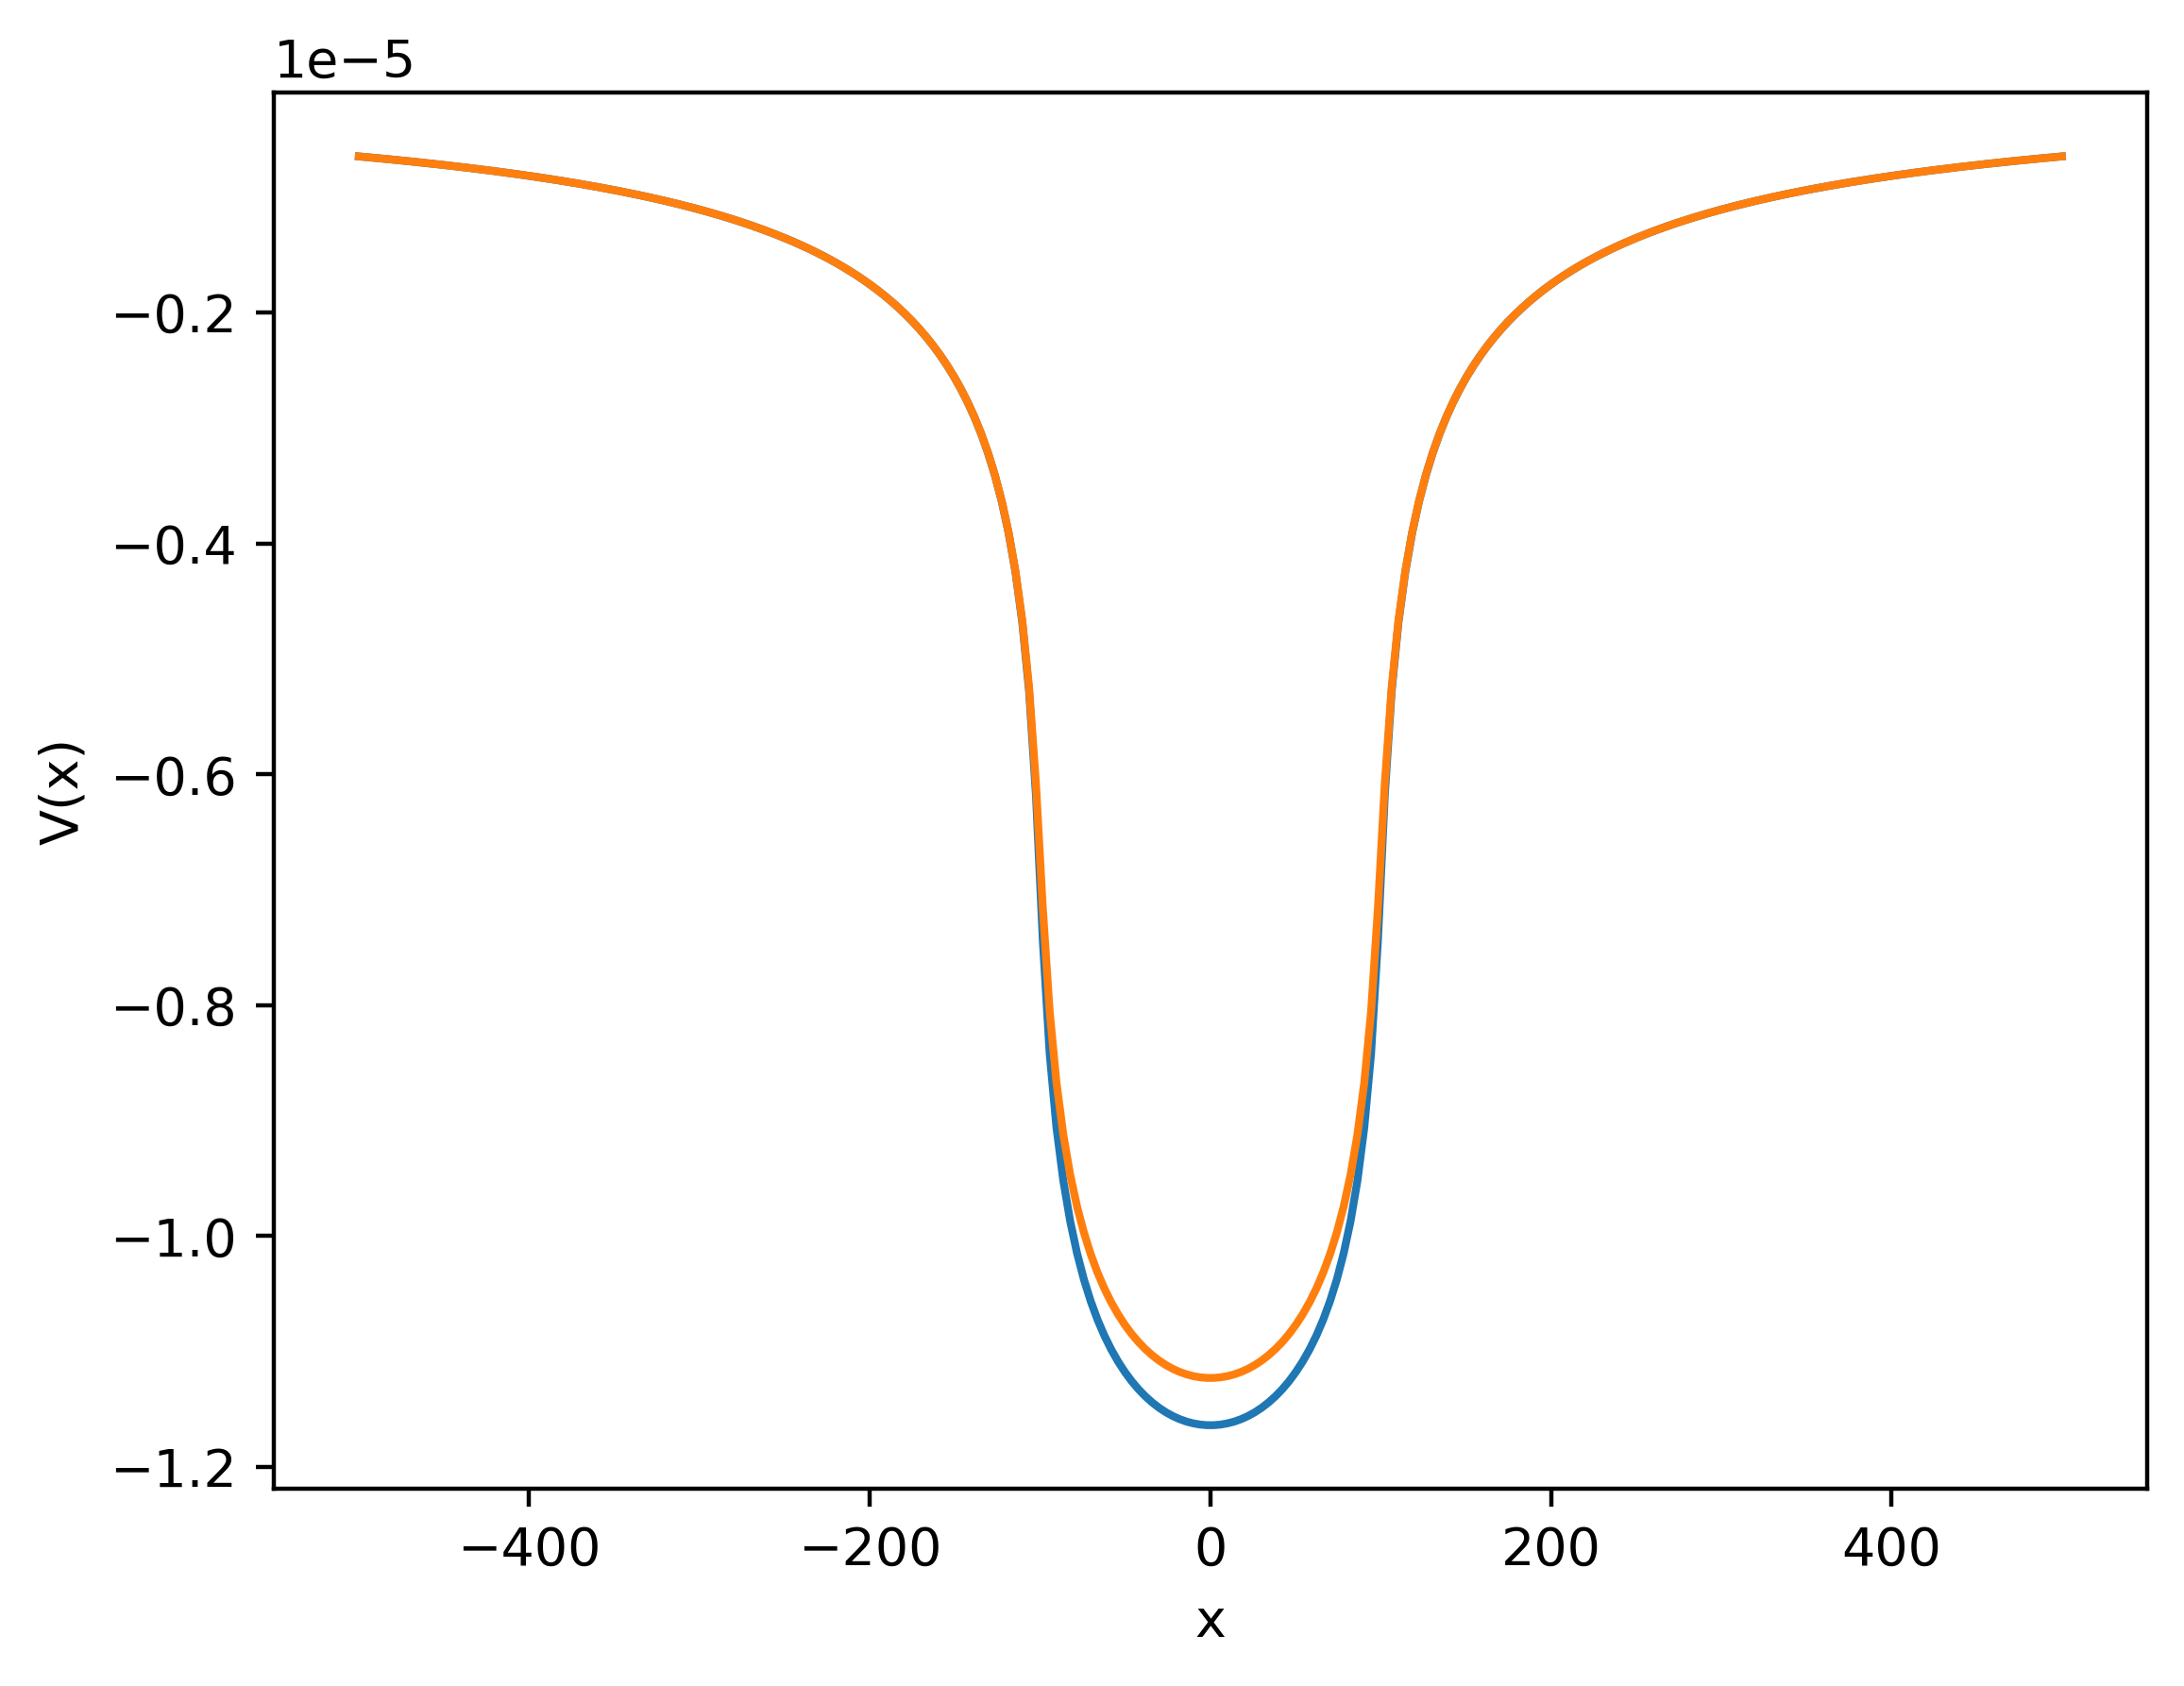

In [76]:
x_arr = np.linspace(-500, 500, 250, endpoint=True)
v_list1 = []
v_list2 = []
for i in x_arr:
    # print(f"potential at point x = {i}: {V(i, 0, 10, 0)}")
    v_list1 = np.append(v_list1, V(i, 0, 3, 0)[0])
    v_list2 = np.append(v_list2, V(i, 0, 3.1, 0)[0])

x_arr_diff = (x_arr[:-1] + x_arr[1:]) * 0.5
plt.rcParams["figure.dpi"] = 400

plt.plot(x_arr, v_list1)
plt.plot(x_arr, v_list2)
plt.ylabel("V(x)")
plt.xlabel("x")
plt.show()

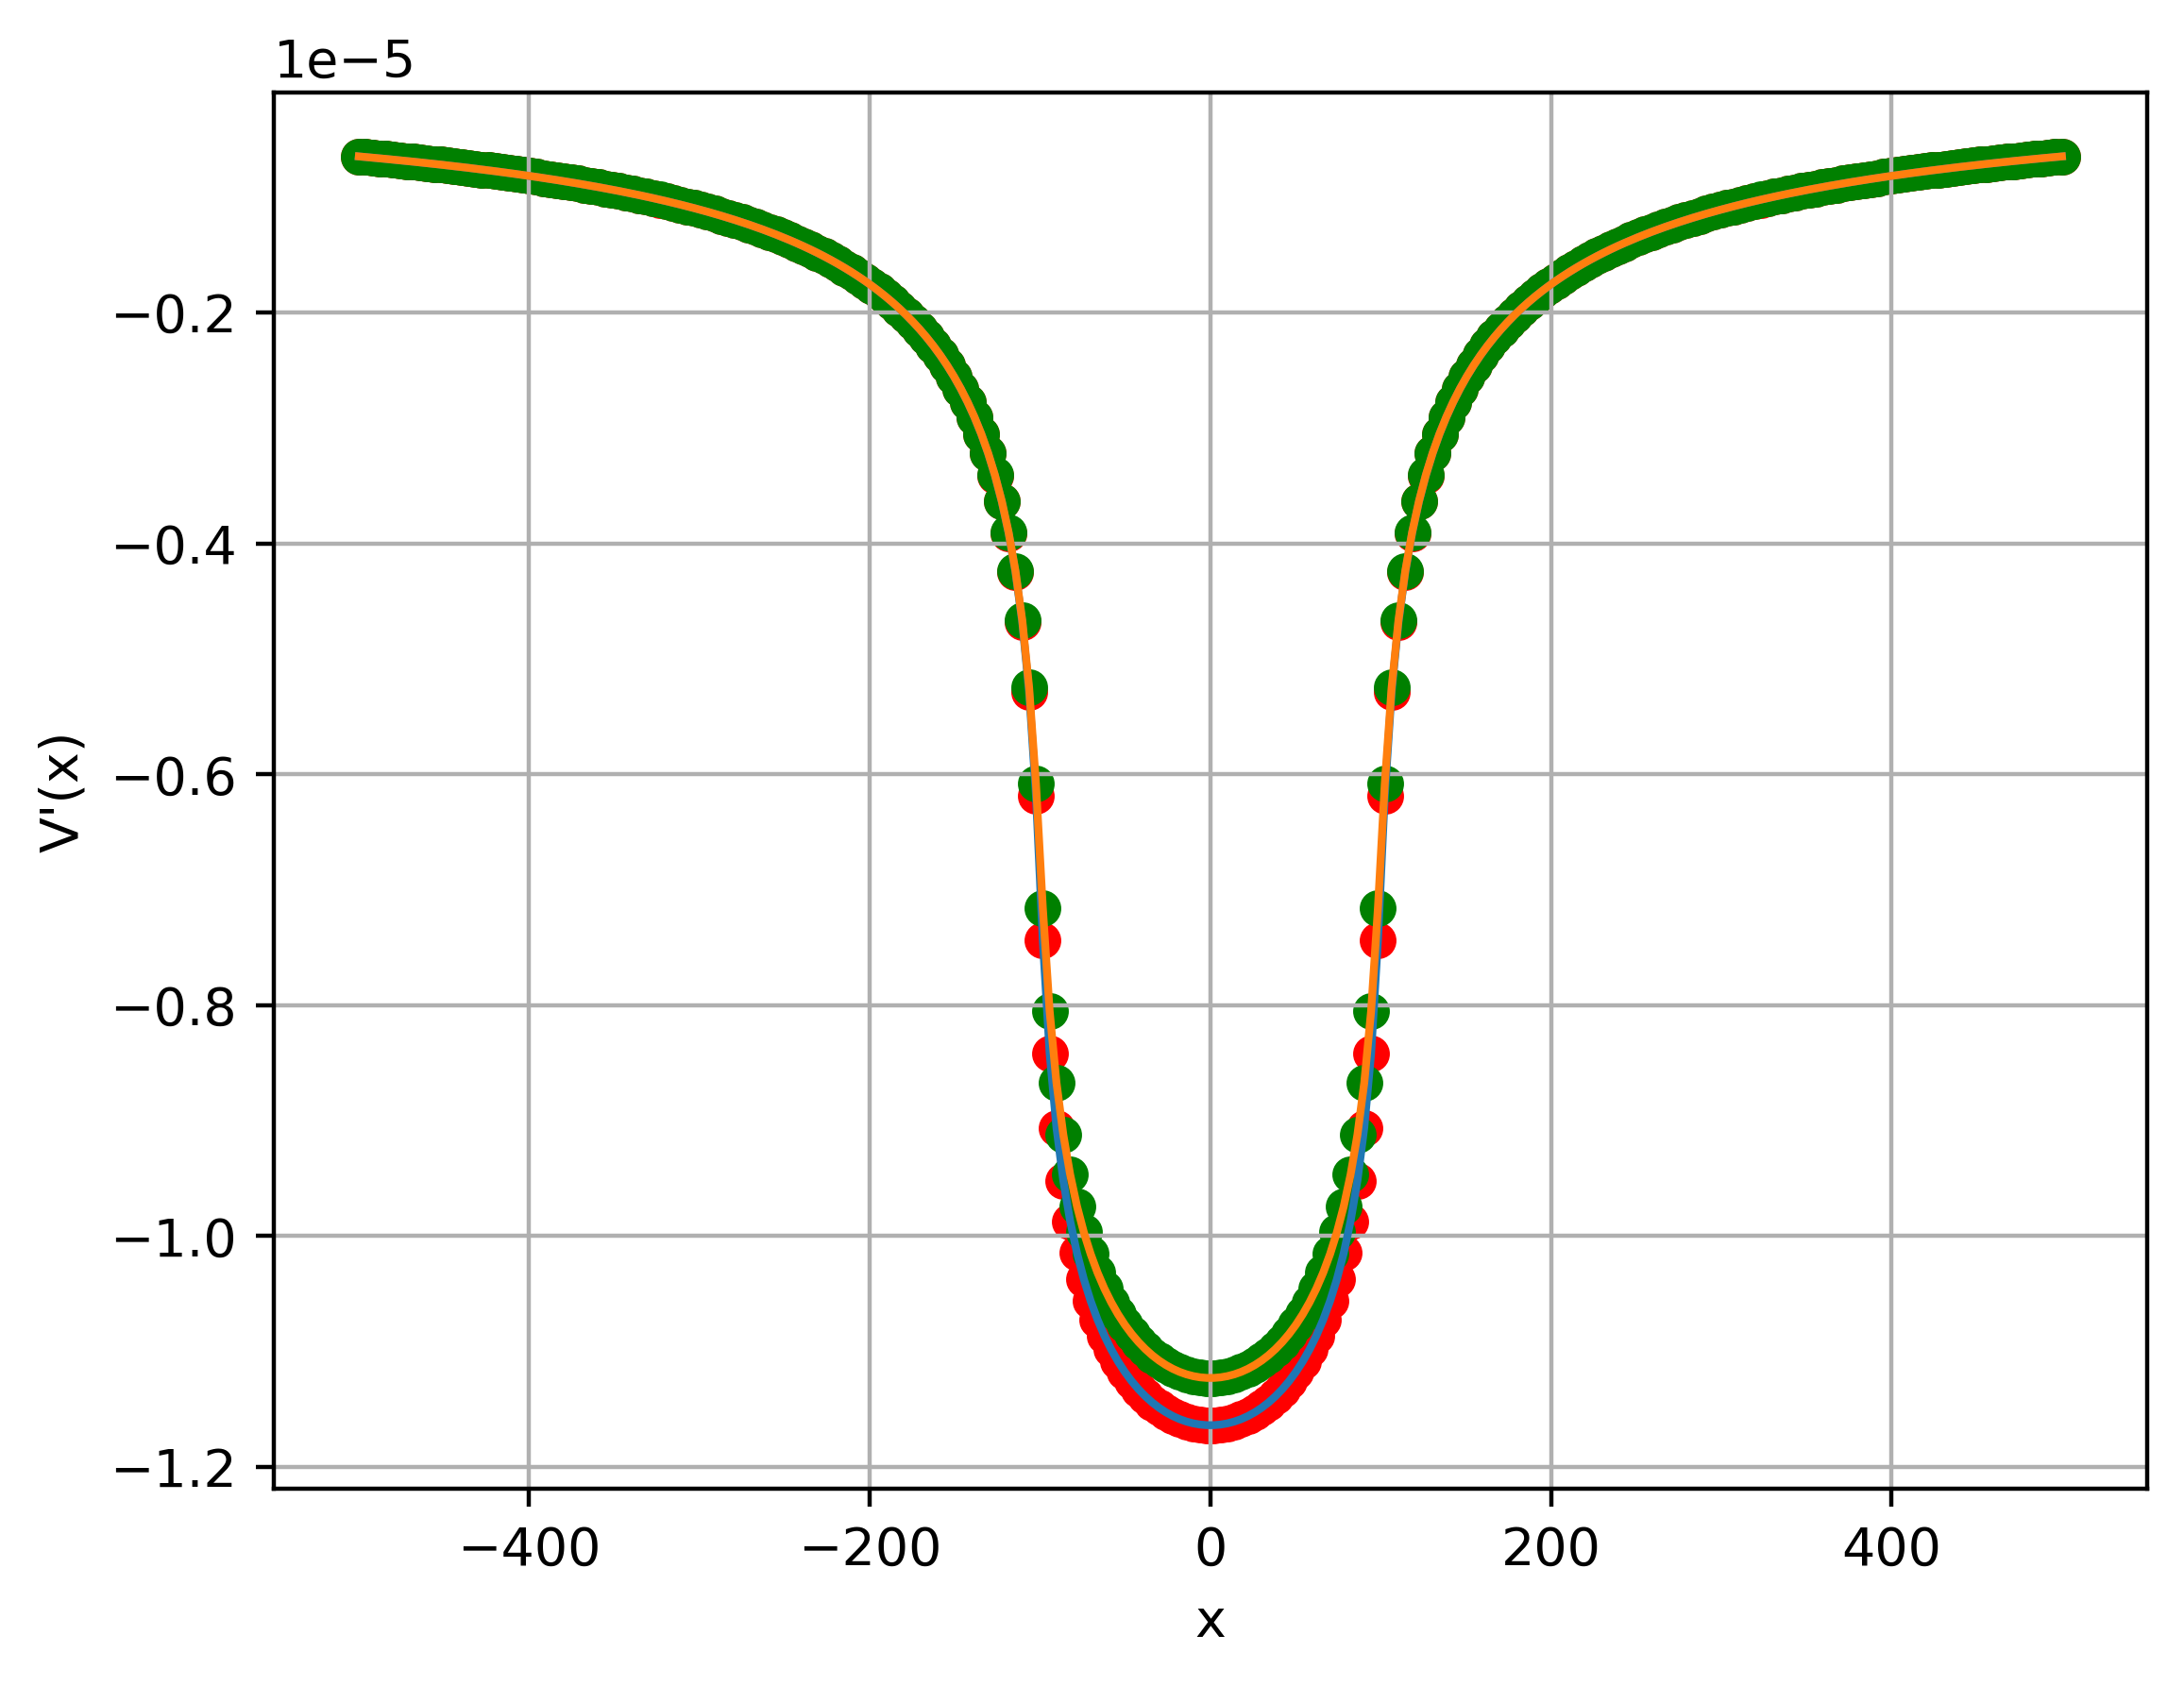

In [77]:
# force plot
from scipy.interpolate import interp1d 

f_approx1 = interp1d(x_arr, np.array(v_list1), kind="cubic")
f_approx2 = interp1d(x_arr, np.array(v_list2), kind="cubic")

plt.scatter(x_arr, np.array(v_list1), color="red")
plt.plot(x_arr, f_approx1(x_arr))
plt.scatter(x_arr, np.array(v_list2), color="green")
plt.plot(x_arr, f_approx2(x_arr))
plt.xlabel("x")
plt.ylabel("V'(x)")
plt.grid()
plt.show()

Which makes complete physical sense- so what happens at the boundaries? Lets now compute what happens when our mass and spring system passes over the top, and see what we would expect to measure. We will assume that the distance the masses inside the system move distances small enough that the gravitational affect from between the top and the bottom of their oscillation is negligible- but we will also assume that the seismometers are sufficient far apart that the difference in gravitational acceleration they experience is significant.

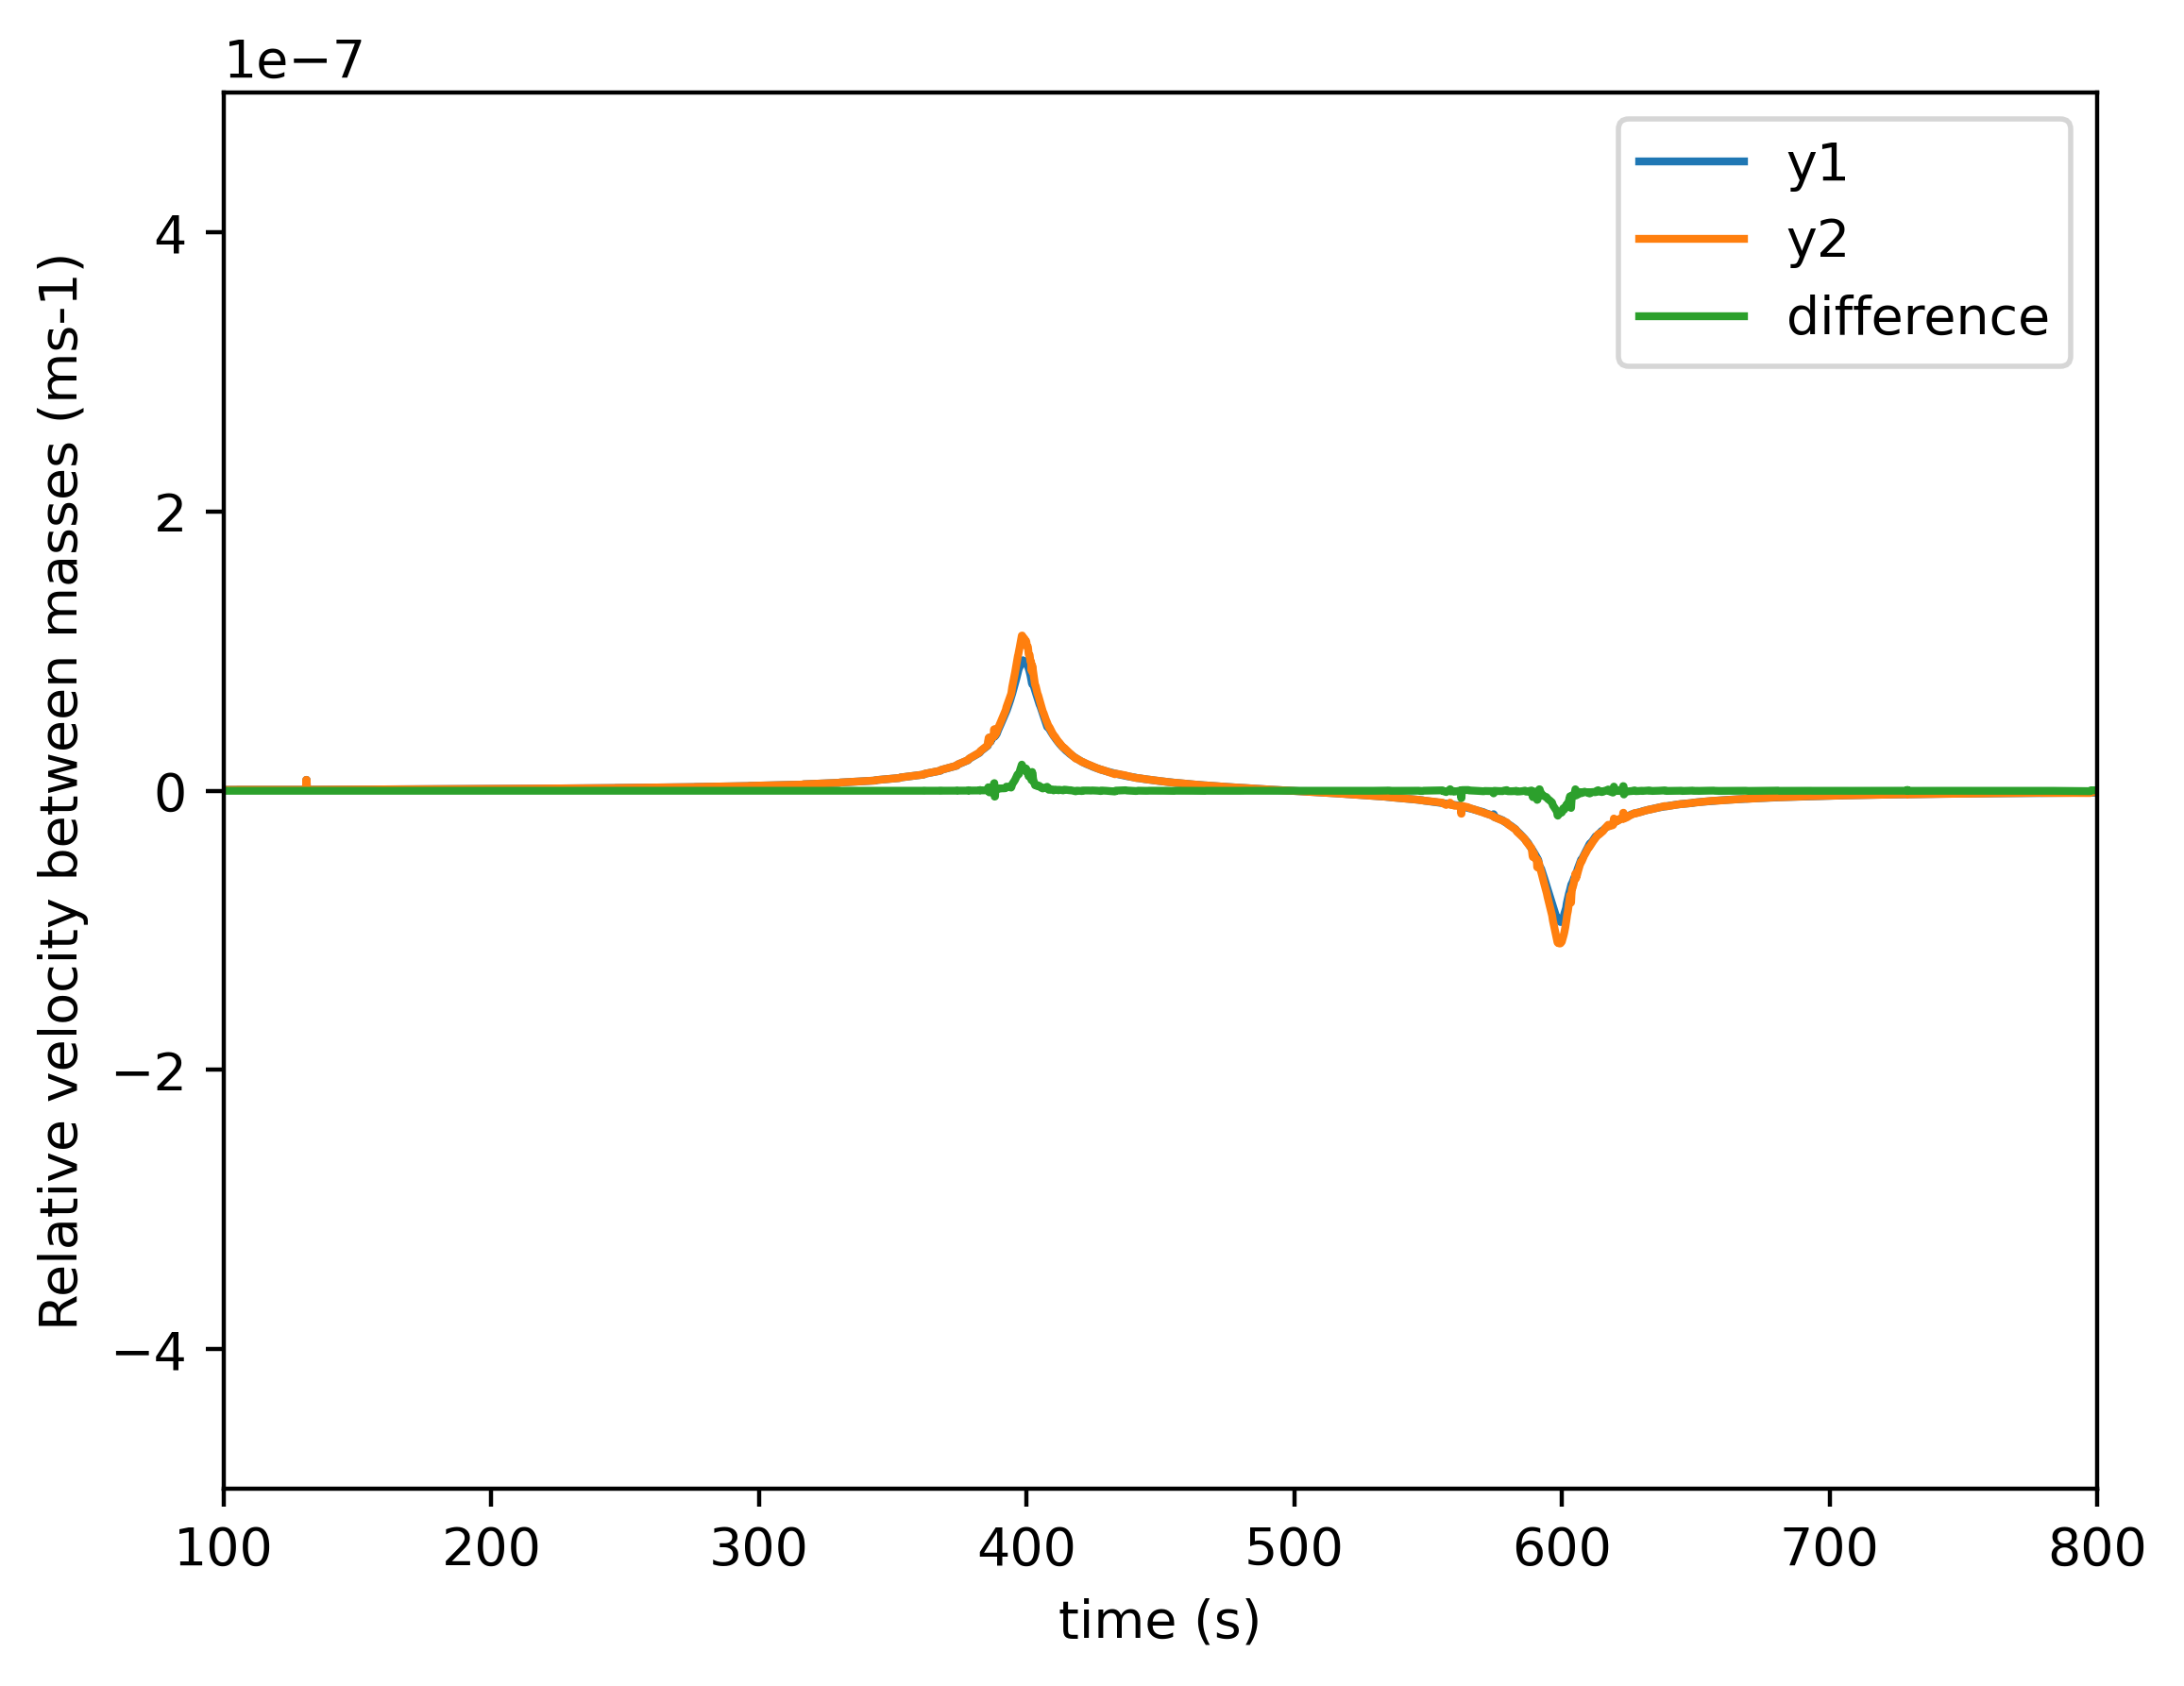

In [81]:
from scipy.integrate import odeint
#t = np.linspace(0, 40, 1000)
# range of interpolation is -500 to 500
t_array = np.linspace(0, 800, 6000)

bw = 800 / 60000
def pathx(t_arr):
    v0 = 1.0
    return v0 * t_arr - 499

def spring_system1(state, t_arr, z1, Q, omega_0):
    z, pz = state
    z_dot = pz
    pz_dot = -(omega_0 ** 2) * z - 100*f_approx1(pathx(t_arr)) - (omega_0 / Q) * pz
    return pz_dot, z_dot

# (omega_0 / Q) * pz
# - f_approx1(pathx(t_arr))
def spring_system2(state, t_arr, z1, Q, omega_0):
    z, pz = state
    z_dot = pz
    pz_dot = -(omega_0 ** 2) * z - 100*f_approx2(pathx(t_arr)) - (omega_0 / Q) * pz
    return pz_dot, z_dot 

#f_approx2(pathx(t_arr))
state0 = (0,0)
p = 1.0, 0.29, 2*np.pi
sol_y1, sol_p1 = odeint(spring_system1, state0, t_array, p, tfirst=False).T
sol_y2, sol_p2 = odeint(spring_system2, state0, t_array, p, tfirst=False).T

plt.plot(t_array, np.gradient(sol_y2), label="y1")
# plt.plot(t_array, f_approx1(pathx(t_array)))
# plt.plot(t_array, f_approx2(pathx(t_array)))
plt.plot(t_array, np.gradient(sol_y1), label="y2")
plt.plot(t_array, np.gradient(sol_y1 - sol_y2), label="difference")
plt.xlim((100,800))
plt.ylim((-5e-7, 5e-7))
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Relative velocity between masses (ms-1)")
plt.show()

In [107]:
# an alternate method we can use involves using the second derivative in the y direction at a paticular point
# this can be slightly more computationally expensive, but offer a better resolution
x_arr = np.linspace(-500, 500, 100, endpoint=True)
v_list1 = []
v_list2 = []
v_list3 = []
for i in x_arr:
    # print(f"potential at point x = {i}: {V(i, 0, 10, 0)}")
    v_list1 = np.append(v_list1, V(i, 0, 3.5, 0)[0])
    v_list2 = np.append(v_list2, V(i, 0, 3.0, 0)[0])
    v_list3 = np.append(v_list3, V(i, 0, 2.5, 0)[0])
    
deriv1 = (v_list1 - v_list2) / 0.1
deriv2 = (v_list2 - v_list3) / 0.1
deriv_2 = (deriv1 - deriv2) / 0.1

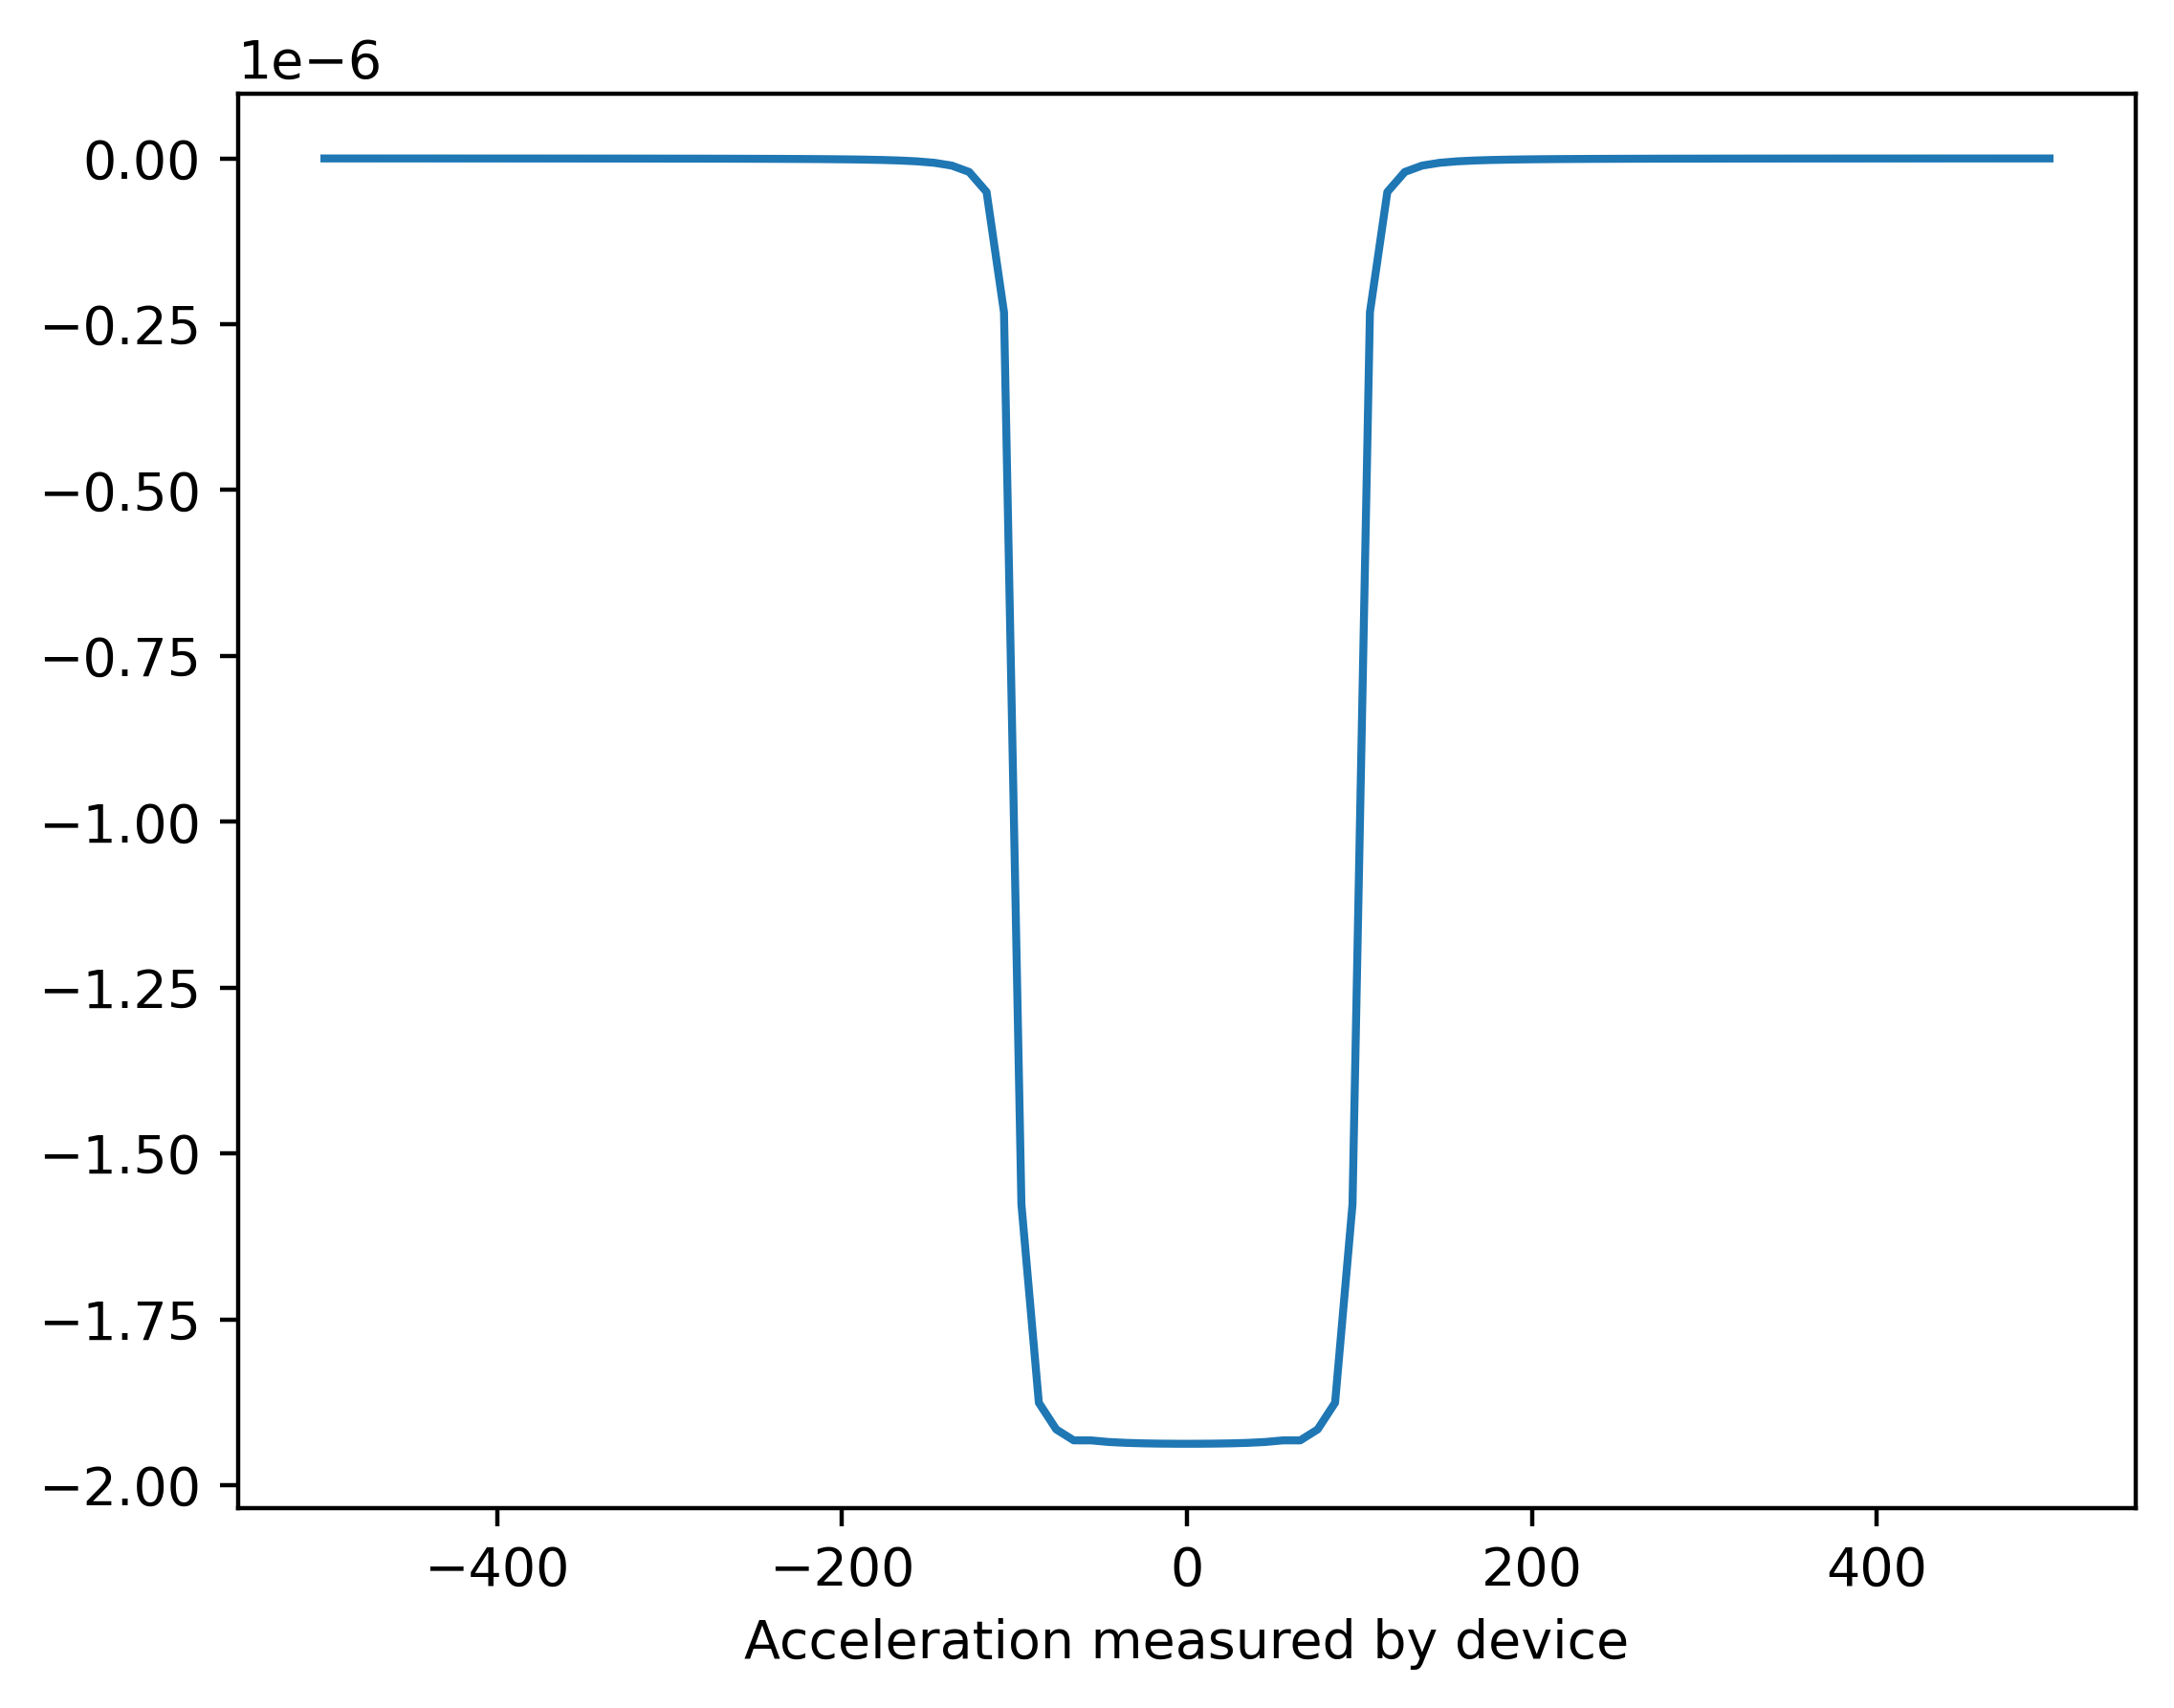

In [108]:
d = 0.1
# plt.plot(x_arr, 2 * deriv_2 * d)

plt.xlabel("Acceleration measured by device")
plt.plot(x_arr, -deriv1)
plt.show()

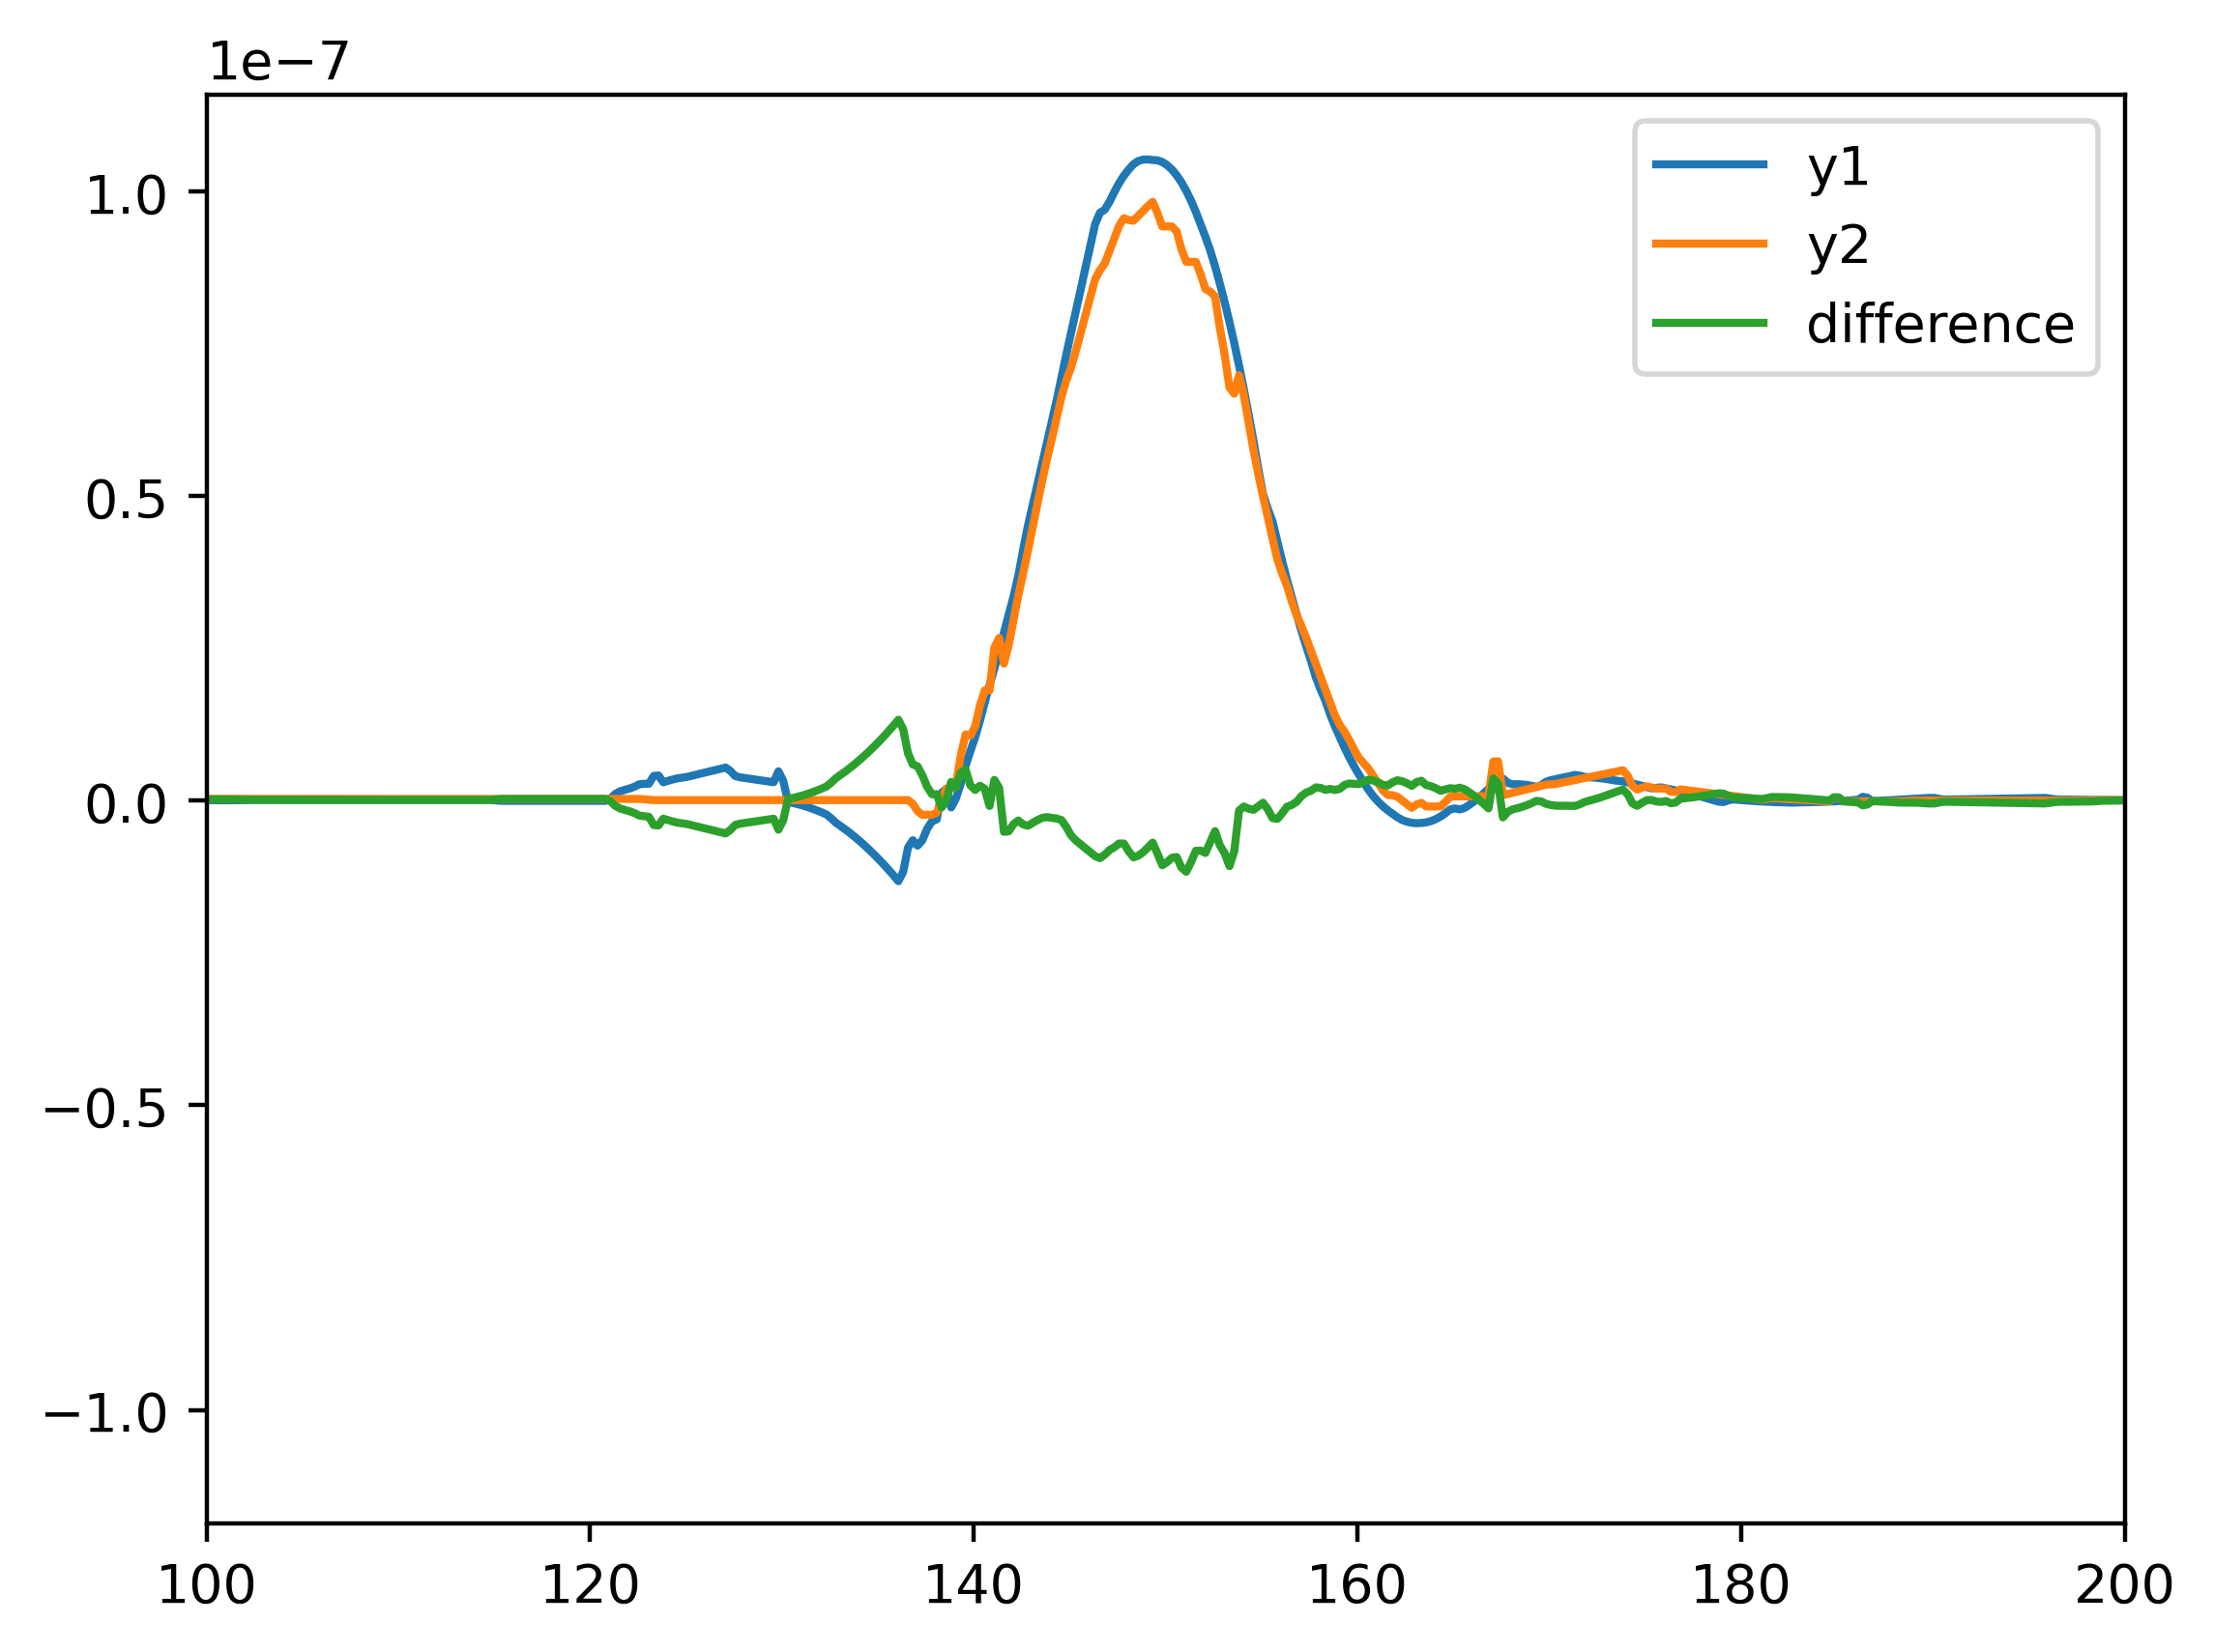

In [110]:
f_approx1 = interp1d(x_arr, np.array(-1*deriv1), kind="cubic")
f_approx2 = interp1d(x_arr, np.array(-1*deriv2), kind="cubic")
bw = 800 / 60000
t_array = np.linspace(0, 500, 2000)

def pathx(t_arr):
    v0 = 1.0
    return v0 * t_arr - 250

def spring_system1(state, t_arr, z1, Q, omega_0):
    z, pz = state
    z_dot = pz
    pz_dot = -(omega_0 ** 2) * z - 100*f_approx1(pathx(t_arr)) - (omega_0 / Q) * pz
    return pz_dot, z_dot

# (omega_0 / Q) * pz
# - f_approx1(pathx(t_arr))
def spring_system2(state, t_arr, z1, Q, omega_0):
    z, pz = state
    z_dot = pz
    pz_dot = -(omega_0 ** 2) * z - 100*f_approx2(pathx(t_arr)) - (omega_0 / Q) * pz
    return pz_dot, z_dot 

#f_approx2(pathx(t_arr))
state0 = (0,0)
p = 1.0, 0.29, 2*np.pi
sol_y1, sol_p1 = odeint(spring_system1, state0, t_array, p, tfirst=False).T
sol_y2, sol_p2 = odeint(spring_system2, state0, t_array, p, tfirst=False).T

plt.plot(t_array, np.gradient(sol_y2), label="y1")
# plt.plot(t_array, f_approx1(pathx(t_array)))
# plt.plot(t_array, f_approx2(pathx(t_array)))
plt.plot(t_array, np.gradient(sol_y1), label="y2")
plt.plot(t_array, np.gradient(sol_y1 - sol_y2), label="difference")
#plt.ylim((-6e-8, 6e-8))
plt.xlim((100,200))
plt.legend()


In [ ]:
# now we will simulate the effect of noise on this data, to see what the power spectrum looks like

